In [30]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import numpy as np
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

In [31]:
# データ読み込み
molecule_db = pd.read_csv('../datas/molecules.csv', names=['id', 'none', 'pubchem_id', 'common_name', 'flavor_profile'], header=0)
flavor_db = pd.read_csv('../datas/flavor_db.csv', names=['id', 'entry_id', 'alias', 'synonyms', 'scientific_name', 'category', 'molecules'], header=0)

flavor_db.drop(['id'], axis=1, inplace=True)
flavor_db.tail()

,,entry_id,alias,synonyms,scientific_name,category,molecules
935,935.0,0,egg,{'Egg'},Chicken,Animal Product,"{6274, 5311110, 644104, 9609, 18827, 527, 1960..."
936,936.0,979,olive oil,{''},Olea europaea L.,additive,"{6184, 31260, 5281168, 8103}"
937,NaN,980,Baking powder,NaN,NaN,NaN,"{11265, 62465, 644104, 12297, 31242, 527, 4114..."
938,NaN,981,Baking soda,NaN,NaN,NaN,{10340}
939,NaN,982,alum,NaN,NaN,NaN,{24856}


In [32]:
molecule_db.tail(20)

,id,none,pubchem_id,common_name,flavor_profile
1771,1771,1771.0,23676745,Potassium Sorbate,{'odorless'}
1772,1772,1772.0,24832101,"Santalol, alpha- and beta-","{'sandalwood', 'sweet', 'woody', 'deep'}"
1773,1773,1773.0,25021769,"2-Propen-1-one, 3-(4-hydroxyphenyl)-1-phenyl-",{'bitter'}
1774,1774,1774.0,44229138,(RS)-norcoclaurinium,"{'milky', 'sweet', 'fruity'}"
1775,1775,1775.0,46779070,S-Methyl 4-methylpentanethioate,{''}
1776,1776,1776.0,53425122,1-(Ethyltrisulfanyl)propane,"{'onion', 'alliaceous', 'green', 'garlic'}"
1777,1777,1777.0,53472027,D-Isoleucine Methyl Ester Hydrochloride,{''}
1778,1778,1778.0,54670067,l-ascorbic acid,{''}
1779,1779,1779.0,57346909,"4H-Pyrrolo[2,1-d]-1,3,5-dithiazine,tetrahydro-...",{''}
1780,1780,1780.0,57357963,33368-82-0,"{'sulfurous', 'alliaceous'}"


In [33]:
flavor_db.tail(2)

,,entry_id,alias,synonyms,scientific_name,category,molecules
938,NaN,981,Baking soda,NaN,NaN,NaN,{10340}
939,NaN,982,alum,NaN,NaN,NaN,{24856}


In [34]:
# kmeans分析のためにベクトル化したflavor_profileを作成してEntryに保存する
# Make all list of all flavors
all_flavors = molecule_db['flavor_profile'].apply(lambda x: x.replace("'", "").strip('{}').split(', ')).tolist()
unique_flavors = list(set([flavor for flavors in all_flavors for flavor in flavors]))
print(unique_flavors)

['', 'cereal', 'chamomile', 'meaty', 'orange', 'weak spice', 'tropica', 'syrup', 'candy', 'cooked beef juice', 'cassia', 'nitrile', 'pistachio', 'soft', 'camphoreous', 'bread crust', 'peach', 'boiled shrimp', 'dry', 'cat-urine', 'cashew', 'blackberry', 'musty', 'peppermint', 'camphor', 'formyl', 'shrimp', 'borneol', 'cheese', 'radish', 'marigold', 'toffee', 'tuberose', 'tangy', 'mesquite', 'smoky', 'laundered cloths', 'roasted peanuts', 'sulfur', 'lactonic', 'deep', 'linden', 'petal', 'honeydew', 'acrylate', 'gravy', 'unripe banana', 'cut grass', 'carrot', 'watermelon', 'minty', 'caramellic', 'crushed bug', 'blossom', 'peppery', 'magnolia', 'filbert', 'pastry', 'grain', 'green bean', 'strong', 'cedarwood', 'cognac', 'fungal', 'fenugreek', 'grapefruit', 'cucumber skin', 'ocimene', 'clam', 'rancid', 'rotten', 'banana', 'solvent', 'thyme', 'hop_oil', 'hawthorne', 'lime', 'gooseberry', 'citrus peel', 'sappy', 'dust', 'arrack', 'cooked', 'lard', 'laundry', 'creosote', 'heavy', 'paint', 'cof

In [35]:
# Word2Vecモデルをロード
model = Word2Vec.load("../datas/fine_tuned_word2vec.model")

# フレーバーのベクトルを確認
green_vector = model.wv['green']
print(green_vector)

[-1.1482652   0.6906382   0.54634637  1.0577378  -0.5062344   0.8183822
 -0.8773969   1.949043    0.5404079  -1.8693726   0.76924515 -0.37203947
  0.2647372   0.8375748  -1.2408557  -2.725684    0.69757015  0.0513288
 -1.2787178  -0.75447536 -0.5638816  -0.6187206   0.10692214  2.083611
 -2.382436   -1.3763132  -1.8717548   0.9849454  -0.43066314  0.82049674
  1.0219861  -2.1720858  -0.19750151  2.0060253  -0.6194169  -1.546091
  1.0671922  -1.0794824  -2.5645182  -1.4762336  -0.8917673   0.72565854
  0.28091452 -1.0379335   2.135398    0.182367   -1.5277311   0.04279294
  0.33289906 -0.7357499  -0.2573414  -1.5321872  -1.3239441   2.0194974
 -0.26635084 -0.02172525 -0.79288495 -0.405699   -0.4961644  -0.9589499
 -0.99865186 -0.569162   -0.94927776 -0.7496103  -0.3602827  -1.6804415
 -2.1441998   0.07358693 -0.81260633 -0.86973464  0.8348748   0.62907577
  1.2948972   0.36297655 -0.5467011   0.47634    -1.3287578   0.15608038
 -0.01936734  0.4359149   0.27084342  0.24584281  1.4932301 

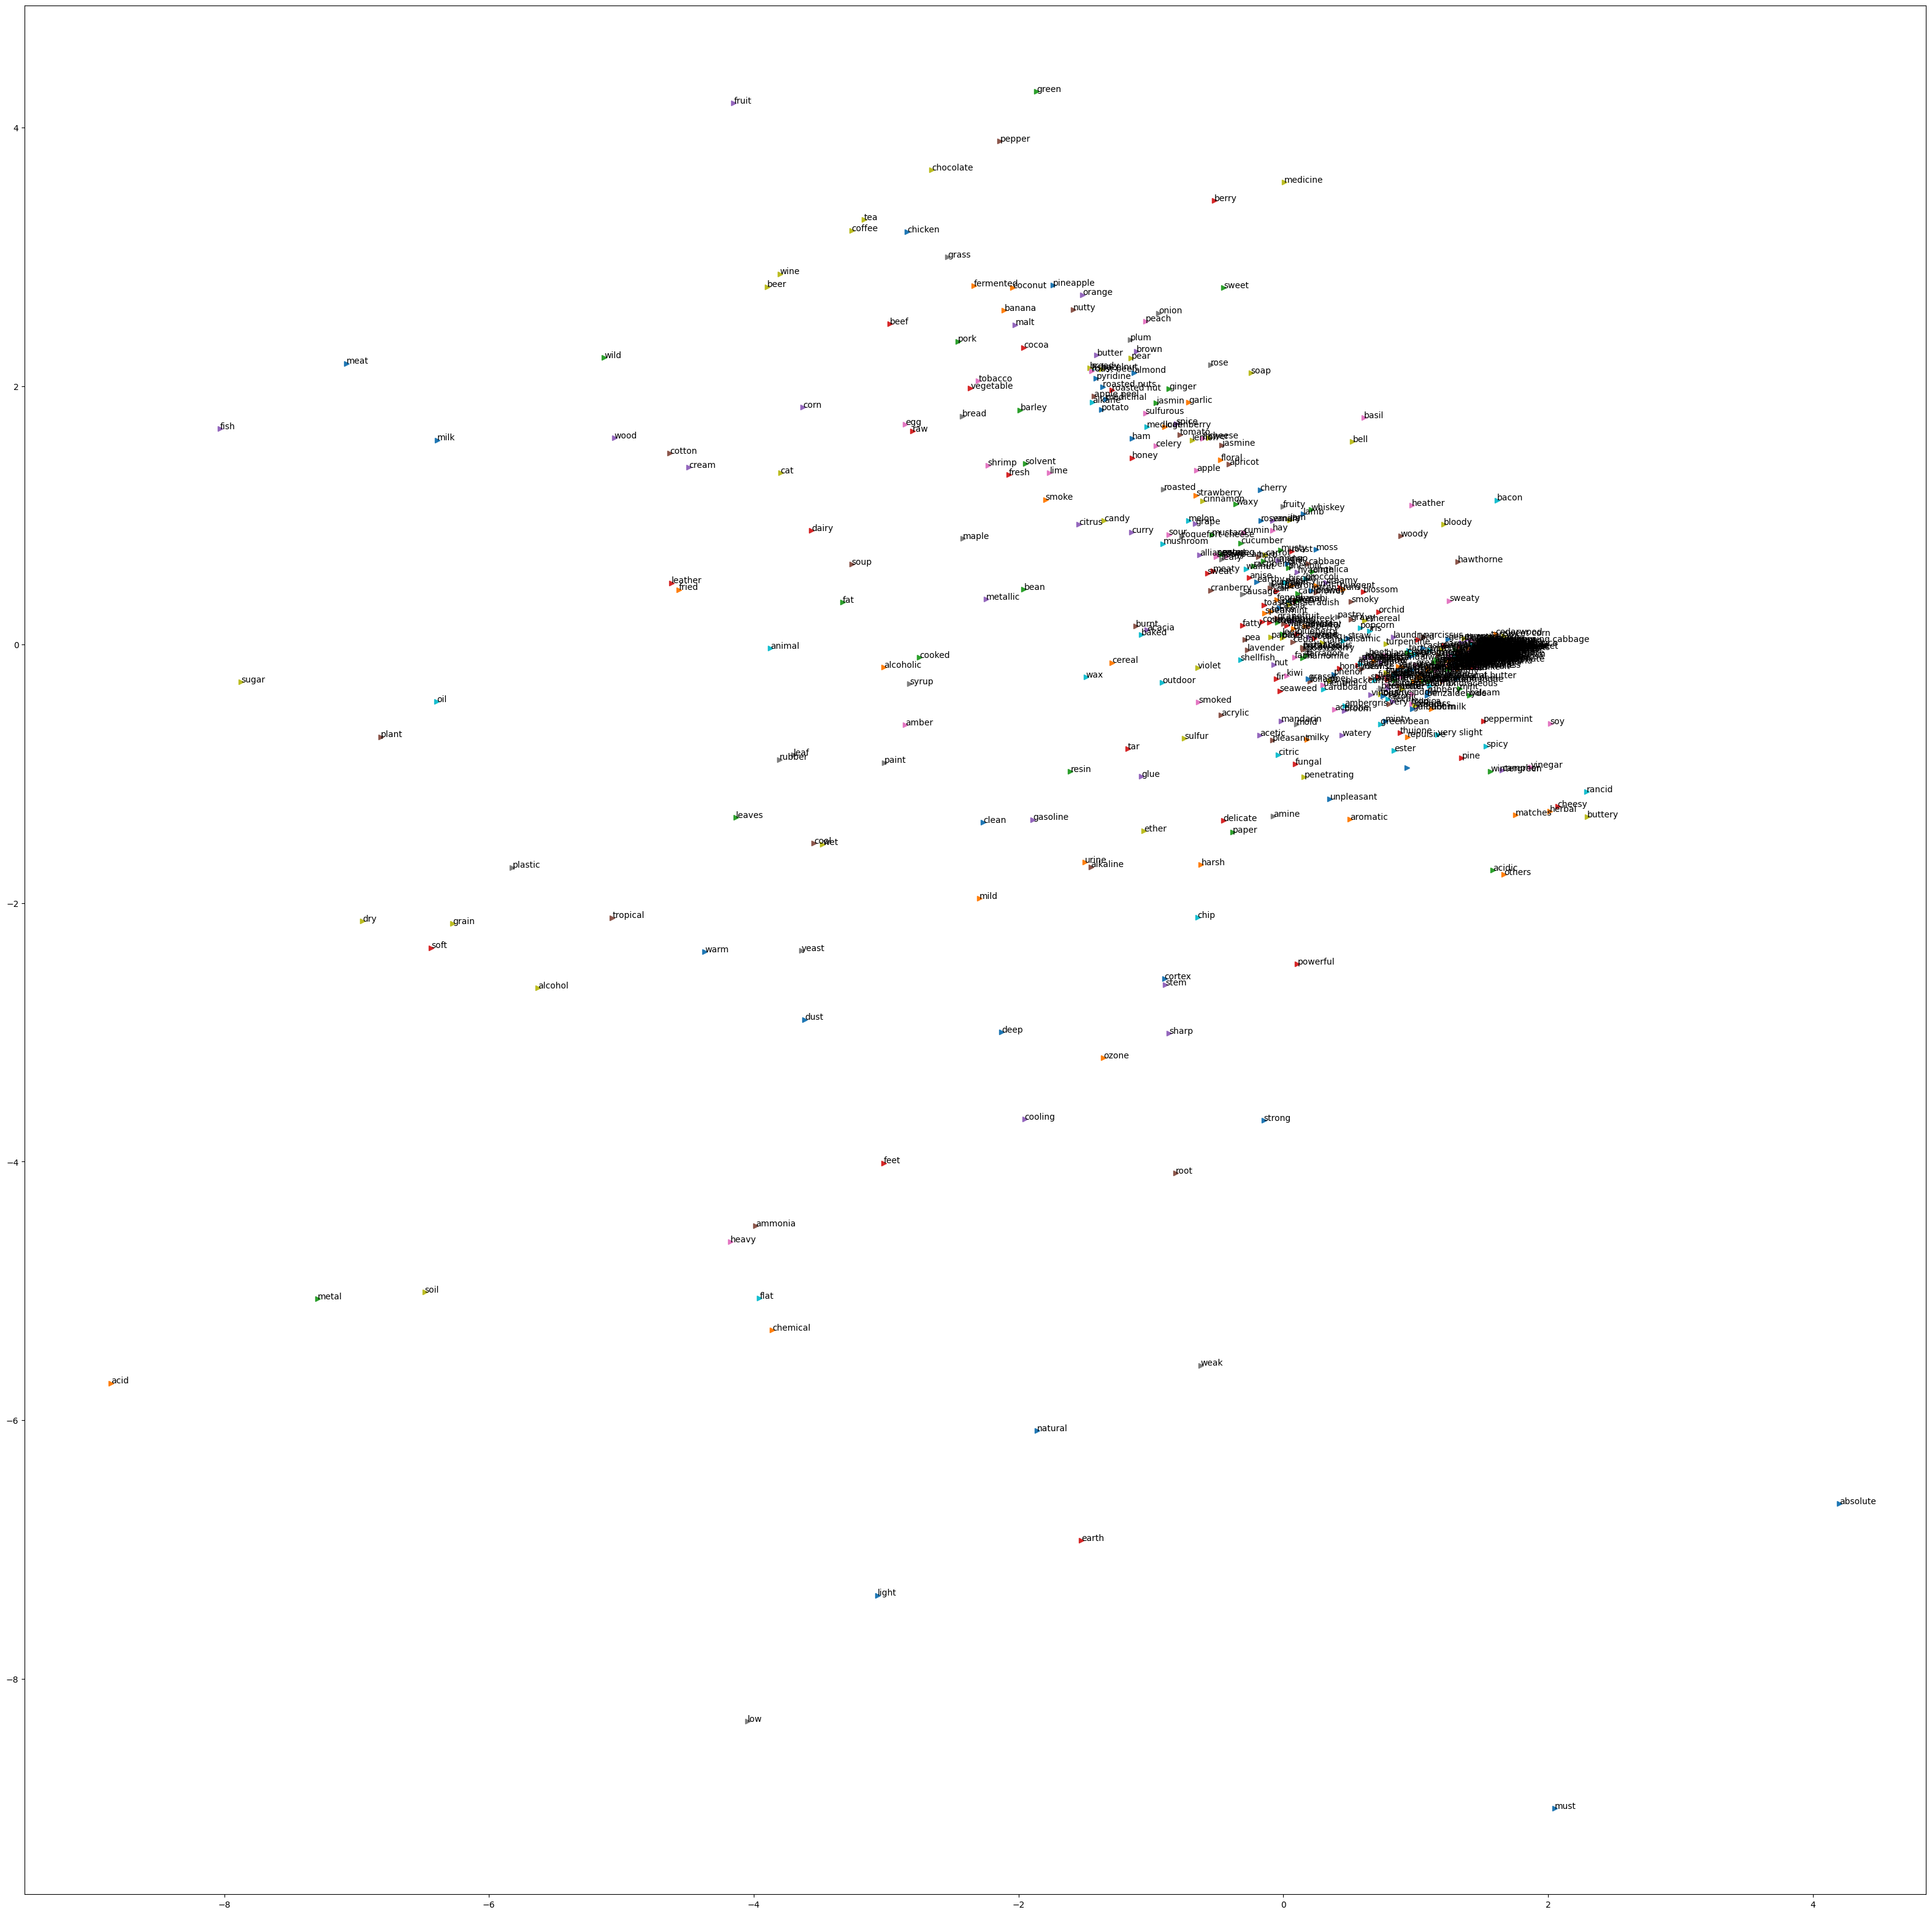

In [36]:
# いくつかの単語のベクトルを取得
wordvecs = []

for flav in unique_flavors:
    wordvecs.append(model.wv[flav])

# 主成分分析
pca = PCA(n_components=3)
pca.fit(wordvecs)

# 射影
X_2d = pca.transform(wordvecs)

# 可視化
plt.figure(figsize=(40, 40))
for i in range(len(unique_flavors)):
    plt.plot(X_2d[i][0], X_2d[i][1], marker='>')
    plt.annotate(unique_flavors[i],(X_2d[i][0], X_2d[i][1]))

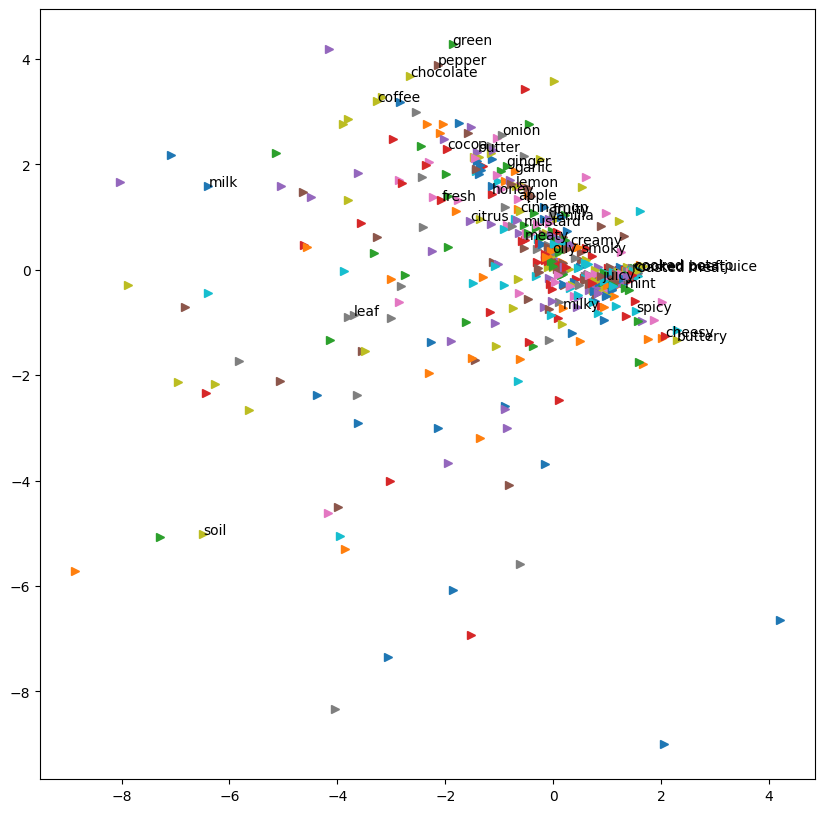

In [38]:
important_words = [
    'citrus', 'vanilla', 'fruity', 
    'lemon', 'chocolate', 'mint', 
    'butter','buttery', 
    'honey', 'cinnamon', 
    'coffee', 'soil',  
    'smoky', 'green',
    'pepper', 'leaf',
    'apple', 'leafy'
    'rose', 'spicy',
    'garlic','onion',
    'ginger','mustard',
    'meaty','cocoa', 'green '
    'fishy','creamy',
    'fruity','milk',
    'milky','juicy','cheesy',
    'cooked beef juice',
    'cooked potato', 'oily',
    'roasted meat', 'beer'
    'roasted nuts', 'woody'
    'spicy','fresh', 'citrus'
]
plt.figure(figsize=(10, 10))

for i in range(len(unique_flavors)):
    if unique_flavors[i] in important_words:
        plt.annotate(unique_flavors[i], (X_2d[i][0], X_2d[i][1]))
    plt.plot(X_2d[i][0], X_2d[i][1], marker='>')

plt.show()